# Problems : 

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It is a real SMS dataset with a spam/ham label for each message. Someone might contact you through an old school way of SMS and you might even skip it because the amount of the spam in your inbox is just way too much. The SMS is classified as spam and is collected through the user's report for unwanted SMS. Can you help us to build a spam classifier?
The problem above urges you to classify whether a text message would be a spam or ham based on the content. We provide the train dataset in sms-train.csv, the data consists of the following variables:

● datetime: Timestamp
● text: The content of message
● status: The label of spam/ham for each message

Use your trained model to predict the label of unseen data provided in sms-unseen.csv. Notice that the column status is intentionally given as missing values (NA). After prediction, save your predicted data to a csv file named submission.csv. The data should contains the following variables:

● datetime: Timestamp
● text: The content of message
● status:Thepredictedlabelofspam/hamforeachmessage


# Background 

Natural Language Processing (NLP) is a branch of Artificial Intelligence concerned with bridging the gap between machines and humans in their natural language. Natural language can take the form of text or sound, and it is used by humans to communicate with one another. NLP can help humans communicate with machines in a more natural way.

Classifying spam and ham messages is one of the most common natural language processing tasks for emails and chat engines. With the advancements in machine learning and natural language processing techniques, it is now possible to separate spam messages from ham messages with a high degree of accuracy.

# Loading The Data 

In [3]:
#import the libraries that will be used 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#loading the data train and have some looks at the first 5 rows. There are columns of datetime, text, and status

sms = pd.read_csv('sms-train.csv')
sms.head()

,datetime,text,status
0,2017-02-15T14:48:00Z,Telegram code 53784,ham
1,2017-02-15T15:24:00Z,Rezeki Nomplok Dompetku Pengiriman Uang! Kirim...,spam
2,2017-02-15T16:07:00Z,WhatsApp code 123-994.\n\nYou can also tap on ...,ham
3,2017-02-15T16:59:00Z,Transaksi travel online pakai CIMB Clicks grat...,ham
4,2017-02-15T18:05:00Z,Apakah Anda mencoba mengakses akun Anda dari p...,ham


# Exploratory Data Analysis (EDA)

In [80]:
#to check type of each column 
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2004 entries, 0 to 2003
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  2004 non-null   object
 1   text      2004 non-null   object
 2   status    2004 non-null   object
dtypes: object(3)
memory usage: 47.1+ KB


In [81]:
#to get the desciption in each column including count, unique, top, and frequency
sms.describe()

,datetime,text,status
count,2004,2004,2004
unique,1739,1615,2
top,2017-12-09T15:20:00Z,usage,ham
freq,9,25,1162


Just to make sure that each column does not have missing value, we can check one by one using .unique(), to see is there unsecessary unique vaue in the column. aslo, we can use .isnull().sum() to check the sum of null data in the columns. when we find 0, then the data is fine. 
but if we find, there is a null data, then we need to handle the missing value.

There are 5 method that we can use.
1. drop missing value --> if we find that the missing value is too much, usually more than 50% of the data. 
using dropna, axis = 0 for row and axis = 1 for column

2. filling with mean and median --> usually for numeric data 
using mean()

3. filling with modus --> usually for categorical data 
using value.counts() to get the modus and then replace the missing value with fillna()

4. filling with bfill or ffill --> it will handle the missing value by replace it with the value before or after the data
bfill, data will be filled by the data in front of it 
ffill, data will be filled by the data behind it 

5. KNN --> by seeing the nearest neighbour of the data
we can use by this method by import from sklearn
from sklearn.input import KNNImputer

In [82]:
sms['status'].unique()

array(['ham', 'spam'], dtype=object)

In [83]:
sms['datetime'].isnull().sum()

0

In [84]:
sms['status'].isnull().sum()

0

In [85]:
sms['text'].isnull().sum()

0

In [4]:
from datetime import datetime, time
sms['datetime'] = pd.to_datetime(sms['datetime'])
sms["hour"] = sms["datetime"].dt.hour

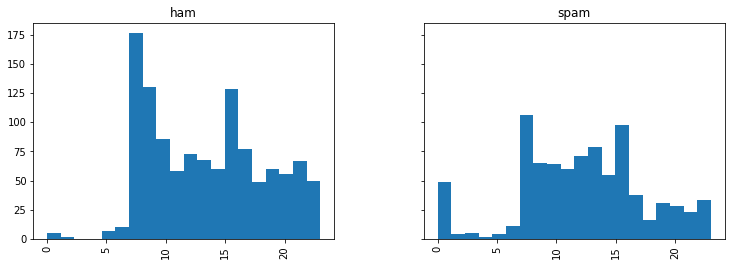

In [5]:
#total hourly frequency for each sms status

sms.hist(column='hour',by='status',bins=20,figsize=(12,4), sharey = True, sharex = True)

plt.show()

This is the total hourly frequency for each sms status. however it is a bit difficult to compare since it is side by side. so we will overlap both of them, so that we can compare them easily. with the alpha, we can adjust the transparency of the graph. we can reduce the transparency of spam message's graph so that we still can see the ham message behind it clearly.

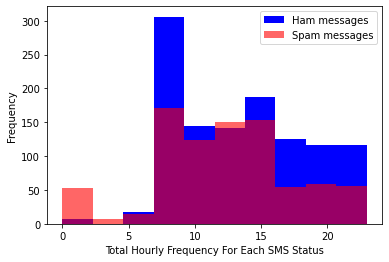

In [6]:
#compare hourly frequency for both sms status 

plt.figure ()
sms[sms.status=='ham'].hour.plot(kind='hist', color='blue', 
                                       label='Ham messages')
sms[sms.status=='spam'].hour.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Total Hourly Frequency For Each SMS Status")
plt.show()

It can be seen that the highest frequency hour for both spam and ham is at 7 am in the morning, and the lowest frequency at 4 am for both

In [7]:
#create new column for the text length

sms['text_len'] = sms.text.apply(len)
sms.tail()

,datetime,text,status,hour,text_len
1999,2018-03-31 05:40:00+00:00,PAKET BRONET 4G OWSEM 4GB 30hr Rp38900 kamu su...,spam,5,151
2000,2018-03-31 13:02:00+00:00,"AGAR TDK DIBLOKIR,sgr registrasi ulang kartu p...",spam,13,151
2001,2018-03-31 13:04:00+00:00,PERHATIAN!\nKartu AXIS-mu sdh dlm masa peringa...,ham,13,149
2002,2018-03-31 13:07:00+00:00,"Asik nih!Balas YA, Km bisa menangin:\n- Rp 500...",spam,13,159
2003,2018-03-31 21:17:00+00:00,Dimana de ?,ham,21,11


To see more characteristics of both spam and ham, we create a new column names text_len to see the length of the text. by using groupby() and describe(), we can see the description of ham and spam, including the frequency/count, mean, std, min, max, and quantile

In [8]:
#to see length of the message for both spam and ham

sms.groupby('status')['text_len'].describe()

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
ham,1162.0,71.517212,63.943128,2.0,21.25,47.0,128.0,878.0
spam,842.0,139.205463,26.948347,2.0,126.00,149.0,158.0,227.0


Text(0, 0.5, 'Frequency')

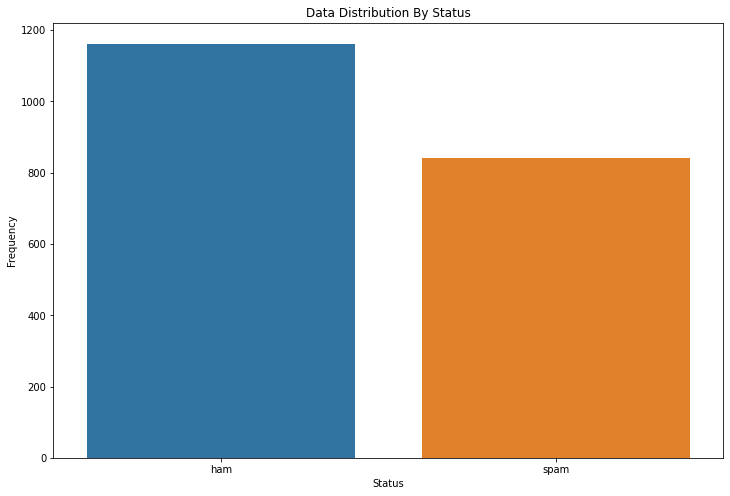

In [9]:
#to see data distribution by status, ham or spam 

plt.figure(figsize=(12,8))
fig = sns.countplot(x= sms["status"])
fig.set_title("Data Distribution By Status")
fig.set_xlabel("Status")
fig.set_ylabel("Frequency")


From the graph, we can get that the frequency for ham message is 1162, while the frequency for spam message is 842

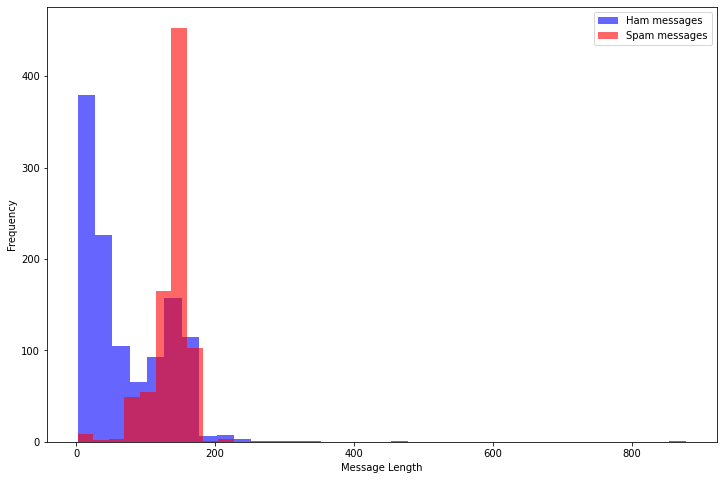

In [10]:
plt.figure (figsize = (12,8))
sms[sms.status=='ham'].text_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
sms[sms.status=='spam'].text_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")
plt.show()

Through this plot can be seen that most of the text length for both spam message and ham message is less than 200 characters, but in general, spam message has a longer text with mean of 139 characters compare to ham message with mean only 71 characters 

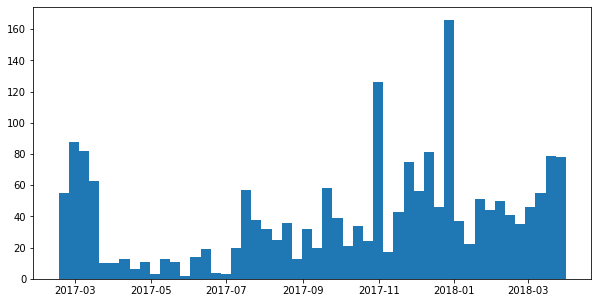

In [11]:
# To plot monthly total hourly frequency for both sms status
fig, ax = plt.subplots(figsize = (10,5))
ax.hist(sms['datetime'], bins = 50)
plt.show()

it can be seen that at the end of 2017 and the beginning of 2018 are peak for text frequency. it might be happen due to the promotion of end/start of the year.

# Data Pre-processing

The data cleaning process NLP is crucial. The computer doesn’t understand the text. For the computer, it is just a cluster of symbols. The main issue we have with our data is that it is all in text format (strings). In order to perform the classification task, the classification algorithms that we typically use require some kind of numerical feature vector. 

There are numerous methods for converting a corpus to vector format. The simplest method is the bag-of-words approach, in which each unique word in a text is represented by a single number. In this section, we will convert the raw messages (character sequences) into vectors (sequences of numbers). 



create a function that divides a message into individual words and returns a list. We'll also eliminate very common words ('the,' 'a,' and so on). We will use the NLTK library to accomplish this since it has a lot of useful features. 



As a first step, we will encoding the categorigal data to numerical data, which convert ham to be 0 and spam to be 1. This step is needed as sklearn cant understand categorical input

In [12]:
# convert label to a numerical variable
obj_dict = { 'ham' : 0,
            'spam' : 1
          }

sms['status_num'] = sms['status'].replace(obj_dict)

For the next step, we extract only the alphabetic characters by this we are removing text in square brackets, links, punctuation and words containing numbers. also, we are converting all the characters into lowercase.

In [13]:
# make text lowercase, remove text in square brackets,remove links, punctuation, numbers, emoji, & symbols

import re
import string

#remove emoji, symbols, & html

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
        '', 
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)
    
    return text


sms['text_clean'] = sms['text'].apply(clean_text)

sms.head()

,datetime,text,status,hour,text_len,status_num,text_clean
0,2017-02-15 14:48:00+00:00,Telegram code 53784,ham,14,19,0,telegram code
1,2017-02-15 15:24:00+00:00,Rezeki Nomplok Dompetku Pengiriman Uang! Kirim...,spam,15,159,1,rezeki nomplok dompetku pengiriman uang kirim ...
2,2017-02-15 16:07:00+00:00,WhatsApp code 123-994.\n\nYou can also tap on ...,ham,16,97,0,whatsapp code can also tap on this link to ve...
3,2017-02-15 16:59:00+00:00,Transaksi travel online pakai CIMB Clicks grat...,ham,16,158,0,transaksi travel online pakai cimb clicks grat...
4,2017-02-15 18:05:00+00:00,Apakah Anda mencoba mengakses akun Anda dari p...,ham,18,234,0,apakah anda mencoba mengakses akun anda dari p...


Next, we will be using stopwords. Stopwords are frequently used words (such as few, is, an, etc). These words have meaning in sentence structure, but they make little contribution to language processing in NLP. we will be removing those in order to reduce redundancy in our processing. NLTK library has a set of default stopwords that we can use.

those are the language that are supported by stopwords:
['arabic',
 'azerbaijani',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'greek',
 'hungarian',
 'indonesian',
 'italian',
 'kazakh',
 'nepali',
 'norwegian',
 'portuguese',
 'romanian',
 'russian',
 'spanish',
 'swedish',
 'turkish']
 
 since our text are in bahasa indonesia, then we use 'indonesian'

In [14]:
#remove stopwords

from nltk.corpus import stopwords

stop_words = stopwords.words('indonesian')

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
sms['text_clean'] = sms['text_clean'].apply(remove_stopwords)
sms.head()

,datetime,text,status,hour,text_len,status_num,text_clean
0,2017-02-15 14:48:00+00:00,Telegram code 53784,ham,14,19,0,telegram code
1,2017-02-15 15:24:00+00:00,Rezeki Nomplok Dompetku Pengiriman Uang! Kirim...,spam,15,159,1,rezeki nomplok dompetku pengiriman uang kirim ...
2,2017-02-15 16:07:00+00:00,WhatsApp code 123-994.\n\nYou can also tap on ...,ham,16,97,0,whatsapp code can also tap on this link to ve...
3,2017-02-15 16:59:00+00:00,Transaksi travel online pakai CIMB Clicks grat...,ham,16,158,0,transaksi travel online pakai cimb clicks grat...
4,2017-02-15 18:05:00+00:00,Apakah Anda mencoba mengakses akun Anda dari p...,ham,18,234,0,mencoba mengakses akun perangkat ya mohon klik...


By using wordcloud, we can see the most frequent word appear for both ham and spam text

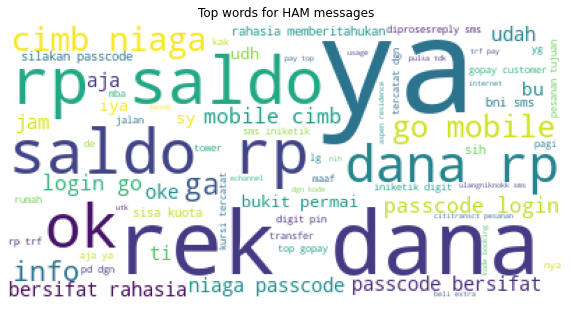

In [16]:
#wordCloud for ham message 

from wordcloud import WordCloud

wc = WordCloud(
    background_color='white', 
    max_words=70, 
    
)
wc.generate(' '.join(text for text in sms.loc[sms['status'] == 'ham', 'text_clean']))
plt.figure(figsize=(10,8))
plt.title('Top words for HAM messages')
plt.imshow(wc)
plt.axis("off")
plt.show()

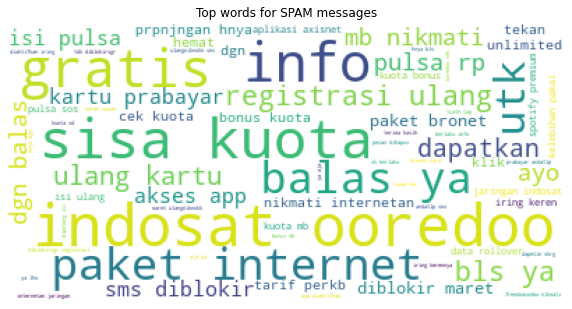

In [17]:
#wordCloud for ham message 
wc = WordCloud(
    background_color='white', 
    max_words=70, 
    
)
wc.generate(' '.join(text for text in sms.loc[sms['status'] == 'spam', 'text_clean']))
plt.figure(figsize=(10,8))
plt.title('Top words for SPAM messages')
plt.imshow(wc)
plt.axis("off")
plt.show()

we also can know the most frequent words appears for ham and spam 

In [18]:
from collections import Counter

words = sms[sms.status=='ham'].text_clean.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(30))

[('ya', 255), ('rp', 160), ('no', 111), ('sms', 93), ('kuota', 80), ('passcode', 72), ('aja', 67), ('saldo', 64), ('dgn', 63), ('trf', 62), ('go', 61), ('registrasi', 60), ('rek', 59), ('top', 57), ('dana', 56), ('ok', 51), ('cimb', 47), ('pulsa', 46), ('mba', 45), ('niaga', 44), ('yg', 43), ('ga', 43), ('paket', 43), ('gopay', 41), ('info', 40), ('mobile', 40), ('berhasil', 40), ('login', 37), ('rahasia', 37), ('pin', 37)]


In [19]:
from collections import Counter

words = sms[sms.status=='spam'].text_clean.apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()

for msg in words:
    spam_words.update(msg)
    
print(spam_words.most_common(30))

[('kuota', 227), ('pulsa', 202), ('ya', 155), ('sms', 151), ('info', 148), ('paket', 143), ('dgn', 142), ('bonus', 128), ('sd', 124), ('beli', 111), ('internetan', 107), ('ooredoo', 106), ('internet', 104), ('nikmati', 100), ('utk', 99), ('rp', 99), ('cek', 94), ('ayo', 91), ('bronet', 90), ('berlaku', 89), ('axis', 88), ('isi', 85), ('indosat', 81), ('gratis', 80), ('aplikasi', 80), ('tarif', 70), ('pelanggan', 69), ('akses', 69), ('iring', 69), ('sisa', 67)]


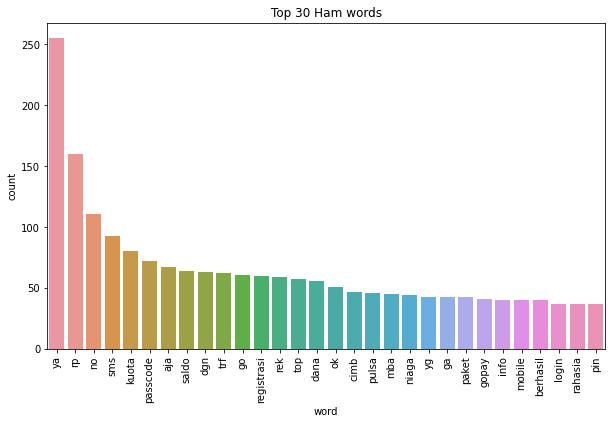

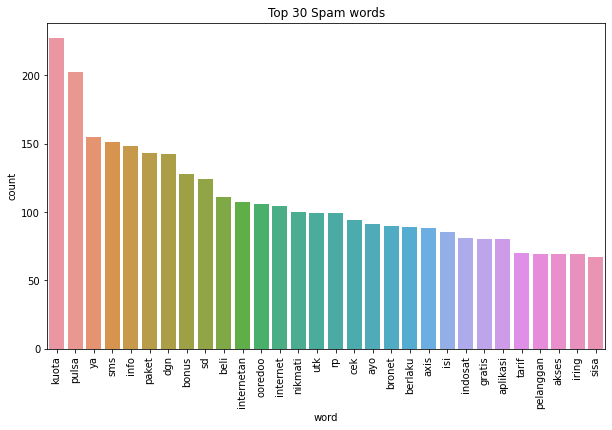

In [20]:
df_hamwords_top30  = pd.DataFrame(ham_words.most_common(30),  columns=['word', 'count'])
df_spamwords_top30 = pd.DataFrame(spam_words.most_common(30), columns=['word', 'count'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_hamwords_top30, ax=ax)
plt.title("Top 30 Ham words")
plt.xticks(rotation='vertical');


fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_spamwords_top30, ax=ax)
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical');

the most frequent word appear for ham text are ya, rp, no, sms.
while for spam text, the most frequent word appear are kuota, pulsa, ya, sms

# Model Building 

In [21]:
#separate data feature and data target

X = sms.text_clean
y = sms.status_num
print(X.shape)
print(y.shape)

(2004,)
(2004,)


Machine learning algorithms learn from the training set, and predictions on the test set are made to evaluate how well the trained machine learning algorithms perform. As a result, we must divide our data into training and test sets. You can accomplish this by calling the train test split() method from the sklearn.model selection module, as shown below:

In [22]:
# split X and y into training and testing sets 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1503,)
(501,)
(1503,)
(501,)


CountVectorizer will convert a collection of text documents to a matrix of token counts. We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message.

in addition, TF-IDF in NLP stands for Term Frequency – Inverse document frequency. In NLP cleaned data needs to be converted into a numerical format where each word is represented by a matrix. This is also known as word embedding or Word vectorization.

Term Frequency (TF) = (Frequency of a term in the document)/(Total number of terms in documents) Inverse Document Frequency(IDF) = log( (total number of documents)/(number of documents with term t)) I will be using TfidfVectorizer() to vectorize the preprocessed data.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(X_train)

# learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.transform(X_train)

# combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)

In [24]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<1503x2442 sparse matrix of type '<class 'numpy.float64'>'
	with 13026 stored elements in Compressed Sparse Row format>

# Building and evaluating a model

**Multinomial Naive Bayes Model**

The Multinomial Naive Bayes algorithm is a popular Bayesian learning method in Natural Language Processing (NLP). Using the Bayes theorem, the program guesses the tag of a text, such as an email or a newspaper story. It computes the likelihood of each tag for a given sample and returns the tag with the highest chance.

In [25]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

CPU times: user 1.82 ms, sys: 102 µs, total: 1.92 ms
Wall time: 1.95 ms


MultinomialNB()

Wall clock time measures how much time has passed, as if you were looking at the clock on your wall.
for the Multinomial Naive Bayes model, the wall time is only 1.89 ms

In [26]:
score = nb.score (X_train_dtm,y_train)
score

0.9634065202927479

nb.score (X_train_dtm,y_train), to see how good the machine learn from data train, we try to avoid overfitting or underfitting. underfitting happen when the model can not read data pattern. Usually if the model underfitting, it can has a high bias and low variance. while for overfitting, it happen because the model really learn well from our data, until the noise also be read. this model usually has low bias and high variance.  

In [27]:
# make predictions for X_test_dtm
y_pred_nb = nb.predict(X_test_dtm)

# calculate accuracy the predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_nb)

0.9580838323353293

Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. The formula for accuracy is (TP + TN)/(TP+TN+FP+FN)

In [28]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_nb)

array([[274,  19],
       [  2, 206]])

Confusion matrix is a table with two rows and two columns that reports the number of true positives, false negatives, false positives, and true negatives. This allows more detailed analysis than simply observing the proportion of correct classifications.

True Positives (TP) - These are the correctly predicted positive values 

True Negatives (TN) - These are the correctly predicted negative values 

False positives and false negatives, these values occur when your actual class contradicts with the predicted class.

False Positives (FP) – When actual class is no and predicted class is yes

False Negatives (FN) – When actual class is yes but predicted class in no.

By using Multinomial Naive Bayes model, we manage to predict the data as below:

TN = 274

FP = 19

FN = 2

TP = 206

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       293
           1       0.92      0.99      0.95       208

    accuracy                           0.96       501
   macro avg       0.95      0.96      0.96       501
weighted avg       0.96      0.96      0.96       501



from the classification report, we can get that the accuracy is 96%, same as what we get in metrics.accuracy_score

precision is the percentage of your correct predictions 

precision for positive = TP/(TP+FP)

precision for negative = TN/(TN+FN)

Recall is the fraction of positives or negatives that were correctly identified.

Recall for positive = TP/(TP+FN)

Recall for negative = TN/(TN+FP)

F-score is the combining of precision and recall of the model, and it is defined as the harmonic mean of the model’s precision and recall.

F1 Score = 2*(Recall * Precision) / (Recall + Precision)


In this case, i think it is better to focus on the ham message, it will be not good if the ham message misclassified as the spam message. since the ham message usually are the important message for us. 

Using Multinomial Naive Bayes model, we got the accuracy of 96%, and for the ham message, we got precision of 99%, recall 94%, and f1-score 96%.

In [30]:
# print message text for false positives (ham incorrectly classifier)
# X_test[(y_pred_nb==1) & (y_test==0)]
X_test[y_pred_nb > y_test]

598     khusus pelanggan  nikmati nonton ribuan film i...
1358                                            km gabut 
270     langganan spotify premium pd  pastikan pulsa u...
1104    khusus pelanggan  nonton ribuan film iflixtanp...
1554    diskon   tambahan diskon    sd  bln utk lemari...
102     sisa kuota  bonus  on  beli extra kuota upgrad...
1307    sisa kuota kuota utama  mb kuota malam   gb be...
1704    skrg aktif  sd   akses unlimited appssmsakses ...
966     khusus pelanggan  nikmati nonton ribuan film i...
1270              menerima pesan nomor  silahkan hubungi 
119     bonus pulsa  dgn lakukan  transaksi finansial ...
1760    preorder samsung galaxy  cashback sd   disc sd...
82      limited offer  pembelian produk berlaku  febru...
3       transaksi travel online pakai cimb clicks grat...
17      ptpertamina bina medika menerima karyawan  jur...
1102    sisa kuota utama   data rollover  berhasil dia...
428     sisa kuota  bonus   data rollover  akses aplik...
453     sisa k

Above are the text for false positives. it should be labeled as ham, but missclassified as spam. if we see from the text, it can be happen because the words used in the text are mostly the frequent words used at spam text such as kuota, pelanggan, sisa. Hence, the ham text is misclassified as spam text. 

In [31]:
# print message text for false negatives (spam incorrectly classifier)
X_test[y_pred_nb < y_test]

1318                                     unreg internet  
1831    find your best fit skinny jeans gratis the bod...
Name: text_clean, dtype: object

And this is the message text for false negatives. it shoudl be labeled as spam but misclassified as ham. 

In [32]:
# calculate predicted probabilities for X_test_dtm 
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9875131268049356

The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve. we get the good score, which is 0.987

# Comparing Model

**Random Forest Classifier Model**

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. 

In [33]:
# import an instantiate a logistic regression model

from sklearn.ensemble import RandomForestClassifier 

rf_clf = RandomForestClassifier() 

# train the model using X_train_dtm

%time rf_clf.fit(X_train_dtm, y_train) 

CPU times: user 409 ms, sys: 6.56 ms, total: 416 ms
Wall time: 417 ms


RandomForestClassifier()

Random Forest Classifier Model spend 419 ms for wall time. it is higher than Multinomial Naive Bayes model whcih only spend 1.89 ms fow wall time.

In [34]:
y_pred_rf = rf_clf.predict(X_test_dtm)

# calculate accuracy of class predictions

from sklearn import metrics

metrics.accuracy_score(y_test, y_pred_rf)

0.9620758483033932

In [35]:
# print the confusion matrix

metrics.confusion_matrix(y_test, y_pred_rf)

array([[280,  13],
       [  6, 202]])

In [36]:
# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_probrf = rf_clf.predict_proba(X_test_dtm)[:, 1]

# calculate AUC
metrics.roc_auc_score(y_test, y_pred_probrf)

0.9951266736676293

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       293
           1       0.94      0.97      0.96       208

    accuracy                           0.96       501
   macro avg       0.96      0.96      0.96       501
weighted avg       0.96      0.96      0.96       501



Using Random Forest Classifier Model, we got the accuracy of 96%, and for the ham message, we got precision of 98%, recall 96%, and f1-score 97%. in addition, the roc auc score is 0.995

**Logistic Regression Model**

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression is estimating the parameters of a logistic model (a form of binary regression). Mathematically, a binary logistic model has a dependent variable with two possible values, such as pass/fail which is represented by an indicator variable, where the two values are labeled "0" and "1". 

In [38]:
# import an instantiate a logistic regression model

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear')

# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 8.06 ms, sys: 2.76 ms, total: 10.8 ms
Wall time: 8.48 ms


LogisticRegression(solver='liblinear')

Logistic regression model spend 7.44 ms. this is lower than Random Forest Classifier Model which spend 419 ms for wall time. But it is still higher than Multinomial Naive Bayes model whcih only spend 1.89 ms fow wall time.

In [39]:
# make class predictions for X_test_dtm
y_pred_lr = logreg.predict(X_test_dtm)

# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_problr = logreg.predict_proba(X_test_dtm)[:, 1]

# calculate accuracy
metrics.accuracy_score(y_test, y_pred_lr)

0.9640718562874252

In [40]:
metrics.confusion_matrix(y_test, y_pred_lr)

array([[283,  10],
       [  8, 200]])

In [41]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_problr)

0.9864137568915726

In [42]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       293
           1       0.95      0.96      0.96       208

    accuracy                           0.96       501
   macro avg       0.96      0.96      0.96       501
weighted avg       0.96      0.96      0.96       501



Using Logistic Regression Model, we got the accuracy of 96%, and for the ham message, we got precision of 97%, recall 97%, and f1-score 97%. in addition, the roc auc score is 0.98

# Predict The Unseen-SMS Data

After comparing the performance of the three models, we can see that multinomial naive bayes is faster in term of time compare to logistic regression and random forest classifier. However, for the accuracy, the three models give the same percentage, which is 96%. 

Since we want to focus on ham message and want to minimize the misclassified of it, then we will compare th precision of ham message of the tree models. 

For multinomial naive bayes, the precision is 99%

For random forest classifier, the precision is 98%

For logistic regression, the precision is 97 %

Hence, to predict the sms-unseen, we will use Multinomial Naive Bayes model based on time efficiency and higher precision.

In [43]:
#loading unseen-sms data
sms_unseen = pd.read_csv('sms-unseen.csv')
sms_unseen.head()

,datetime,text,status
0,2018-03-01T00:32:00Z,Km baru saja akses Apps Sehari-hari terpopuler...,NaN
1,2018-03-01T08:57:00Z,GRATIS UNLIMITED YOUTUBE+INTERNET 10GB+CHAT&SO...,NaN
2,2018-03-01T09:15:00Z,Sisa kuota 285 MB.Beli pkt Internet TERBAIK dr...,NaN
3,2018-03-01T16:42:00Z,Ada banyak lowongan kerja baru! Ayo jgn sampai...,NaN
4,2018-03-01T17:42:00Z,Proses PEMBLOKIRAN kartu bagi yg blm registras...,NaN


In [44]:
# make text lowercase, remove text in square brackets,remove links, punctuation and words containing numbers

import re
import string

def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

sms_unseen['text_clean'] = sms_unseen['text'].apply(clean_text)


#remove stopwords

from nltk.corpus import stopwords

stop_words = stopwords.words('indonesian')

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
sms_unseen['text_clean'] = sms_unseen['text_clean'].apply(remove_stopwords)


#remove emoji, symbols, & html

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
        '', 
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)
    
    return text


sms_unseen['text_clean'] = sms_unseen['text_clean'].apply(clean_text)

sms_unseen.head()

,datetime,text,status,text_clean
0,2018-03-01T00:32:00Z,Km baru saja akses Apps Sehari-hari terpopuler...,NaN,km akses apps seharihari terpopulernikmati aks...
1,2018-03-01T08:57:00Z,GRATIS UNLIMITED YOUTUBE+INTERNET 10GB+CHAT&SO...,NaN,gratis unlimited youtubeinternet rolloverpro...
2,2018-03-01T09:15:00Z,Sisa kuota 285 MB.Beli pkt Internet TERBAIK dr...,NaN,sisa kuota mbbeli pkt internet terbaik dr oo...
3,2018-03-01T16:42:00Z,Ada banyak lowongan kerja baru! Ayo jgn sampai...,NaN,lowongan kerja ayo jgn ketinggalan update tip...
4,2018-03-01T17:42:00Z,Proses PEMBLOKIRAN kartu bagi yg blm registras...,NaN,proses pemblokiran kartu yg blm registrasi sdg...


In [45]:
#predict the data 

X_predict = sms_unseen.text

from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(X_train)

# learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.transform(X_train)

# combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_predict_dtm = vect.transform(X_predict)

# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

CPU times: user 1.38 ms, sys: 9 µs, total: 1.39 ms
Wall time: 1.39 ms


MultinomialNB()

In [46]:
# make class predictions for X_test_dtm
y_pred_class3 = nb.predict(X_predict_dtm)


In [47]:
sms_unseen ['status'] = y_pred_class3

# convert numerical to a label variable
dict2 = { 0 :'ham' ,
          1 : 'spam'
          }

sms_unseen['status'] = sms_unseen['status'].replace(dict2)
sms_unseen

,datetime,text,status,text_clean
0,2018-03-01T00:32:00Z,Km baru saja akses Apps Sehari-hari terpopuler...,spam,km akses apps seharihari terpopulernikmati aks...
1,2018-03-01T08:57:00Z,GRATIS UNLIMITED YOUTUBE+INTERNET 10GB+CHAT&SO...,spam,gratis unlimited youtubeinternet rolloverpro...
2,2018-03-01T09:15:00Z,Sisa kuota 285 MB.Beli pkt Internet TERBAIK dr...,spam,sisa kuota mbbeli pkt internet terbaik dr oo...
3,2018-03-01T16:42:00Z,Ada banyak lowongan kerja baru! Ayo jgn sampai...,spam,lowongan kerja ayo jgn ketinggalan update tip...
4,2018-03-01T17:42:00Z,Proses PEMBLOKIRAN kartu bagi yg blm registras...,ham,proses pemblokiran kartu yg blm registrasi sdg...
...,...,...,...,...
278,2018-04-09T19:37:00Z,09/04/2018 19:36 Pada No. Rek 378088918 ada da...,ham,no rek dana rp saldo rp tarik tunai
279,2018-04-10T13:30:00Z,Ayo nonton video tentang motor sport di *123*5...,spam,ayo nonton video motor sport tarif info kl...
280,2018-04-11T06:02:00Z,Paket internet 1 GB & Unlimited Nelpon SMS ke ...,spam,paket internet gb unlimited nelpon sms rp b...
281,2018-04-11T12:58:00Z,"awas ketinggalan iRing Shae-Up Up n Away, Rp.0...",spam,awas ketinggalan iring shaeup up n away prpnj...


In [49]:
header = ['datetime', 'text', 'status']

#make new csv for submission
sms_unseen.to_csv('submission.csv', columns = header)

# Conclusion

In conclusion, we have successfully build a model to predict ham or spam of data sms. This classifying spam and ham messages is one of the most common natural language processing tasks for emails and chat engines. With the advancements in machine learning and natural language processing techniques, it is now possible to separate spam messages from ham messages with a high degree of accuracy.

By using machine learning, we split the sms data into 2, data train and data test. Data train is used to let the machine learn from the data. while the data test is used to test on how far the machine has learned from the data train. 

For the efficiency, we remove the unnecessary words/characters by using stopwords. and use countvectorizer to convert a collection of text documents to a matrix of token counts. 

In this opportunity, we use Multinomial Naive Bayes, Logistic Regression and Random Forest Classifier. Those 3 give a good accuracy which are 96% , however Multinomial Naive Bayes wins at time efficiency and precision for ham message. Hence, to predict the unseen data, we use Multinomial Naive Bayes. 

